In [12]:
import matlab.engine
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from pathlib import Path

最後要畫
1. weight和真實theta的比較圖(放最小的n)
    - 各自一維的cdf，背景是真實cdf，回報moment：theta1, theta2,  theta1^2, theta2^2, theta1*theta2。然後下面要有真實的比較
2. consistent圖

- 第二階段的theta有平方、有log、有交乘項

- 跑二階段有Z的panel。Z1出現在X，Z2出現在y


In [13]:
eng = matlab.engine.start_matlab()
s = eng.genpath('/home/r10323001/Dual-ALM-for-NPMLE')
eng.addpath(s, nargout=0)
eng.addpath('.', nargout=0)

In [14]:
N = [5000, 8000, 10000]
B = 200

In [15]:
x_cov =  np.array([[0.2, -0.1], [-0.1, 0.2]])
beta = np.array([1.0,2.0,3.0])

x_cov_m = matlab.double(x_cov)
beta_m = matlab.double(beta)

In [16]:
priors = ['uniform', 'normal', 'beta']
second_stages = ['linear', 'square', 'log', 'cross']

In [17]:
def consistent_plot(b_est_df, title=None):
    fig, axs = plt.subplots(1,3,figsize=(14,4))
    
    for i in range(3):
        axs[i].set_title(f'beta_{i}')
        axs[i].axvline(x=beta[i], color='r')
        sns.kdeplot(data=b_est_df, x=i, hue='n', ax=axs[i])
    if title:
        fig.suptitle(title)
    return fig

In [18]:
def assess_prior_plot(grid, weight, theta):
    fig, axs = plt.subplots(1,2,figsize=(14,6))
    for i in range(2):            
            
            axs[i].ecdf(theta[:,i], label='True')
            
            
            axs[i].plot(np.sort(grid[:,i]), np.cumsum(weight), label='NPMLE')
            axs[i].set_title(f'theta {i}')
            axs[i].legend()
            
    return fig
        
            

In [19]:
def assess_prior_table(grid, weight, theta):
    
    estimated_theta = pd.Series(
        {'theta_1': grid[:,0] @ weight,
        'theta_2': grid[:,1] @ weight,
        'theta_1^2': grid[:,0]**2 @ weight,
        'theta_1^2': grid[:,1]**2 @ weight,
        'theta_1*theta_2': (grid[:,0]*grid[:,1]) @ weight,
        }
    )

    true_theta = pd.Series(
        {'theta_1': theta[:,0].mean(),
        'theta_2': theta[:,1].mean(),
        'theta_1^2': (theta[:,0]**2).mean(),
        'theta_1^2': (theta[:,1]**2).mean(),
        'theta_1*theta_2': (theta[:,0] * theta[:,1]).mean()
        }
    )

    return pd.DataFrame([estimated_theta, true_theta], index=['estimated', 'true'])
        

In [20]:
def run_exp(prior, second_stage, run_anyway=False):
    b_est_list = []
    
    title = f'{prior}_{second_stage}'
    p = Path('dim2_combinations') / title
    
    if (not p.is_dir()) or (run_anyway):
        
        p.mkdir(exist_ok=True)
        
        for n in N:
            for b in range(B):
                b_est, grid, weight, theta, y, pm = eng.dim2_twostep(n, prior, second_stage, x_cov_m, beta_m, nargout=6)
                b_est_series = pd.Series(np.array(b_est).reshape(-1))
                b_est_series['n'] = n 
                b_est_list.append(b_est_series)
        b_est_df = pd.DataFrame(b_est_list)
        
        # store mean
        b_est_df.groupby('n').mean().to_csv( p / 'beta_pm.csv')
        
        
        # store fig
        
        consistent_plt = consistent_plot(b_est_df, title)
        consistent_plt.savefig(p /'consistent.png' )
        
        grid = np.array(grid)
        weight = np.array(weight).reshape(-1)
        theta = np.array(theta)
        
        
        prior_plt = assess_prior_plot(grid, weight, theta)
        prior_plt.savefig(p / 'prior_compare.png' )
        
        prior_table = assess_prior_table(grid, weight, theta)
        prior_table.to_csv(p / 'prior.csv')
        

        

/tmp/ipykernel_4085563/4053501369.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,3,figsize=(14,4))


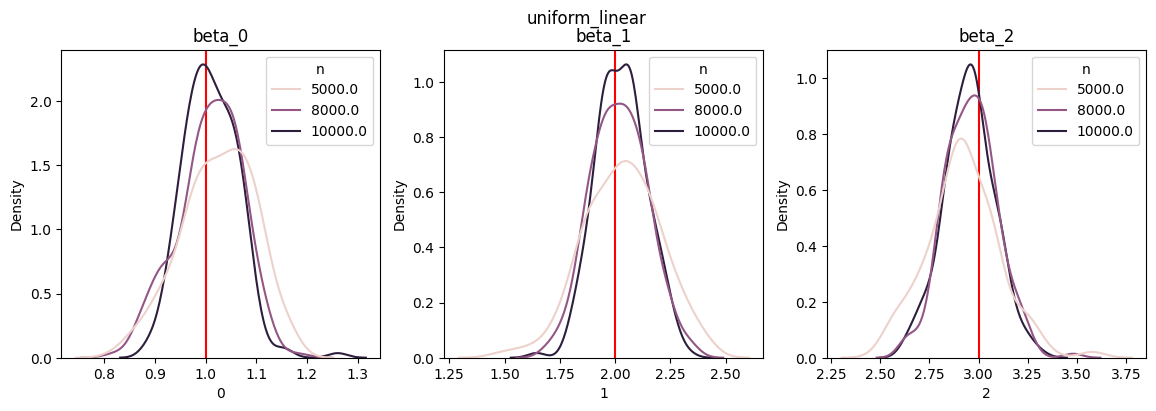

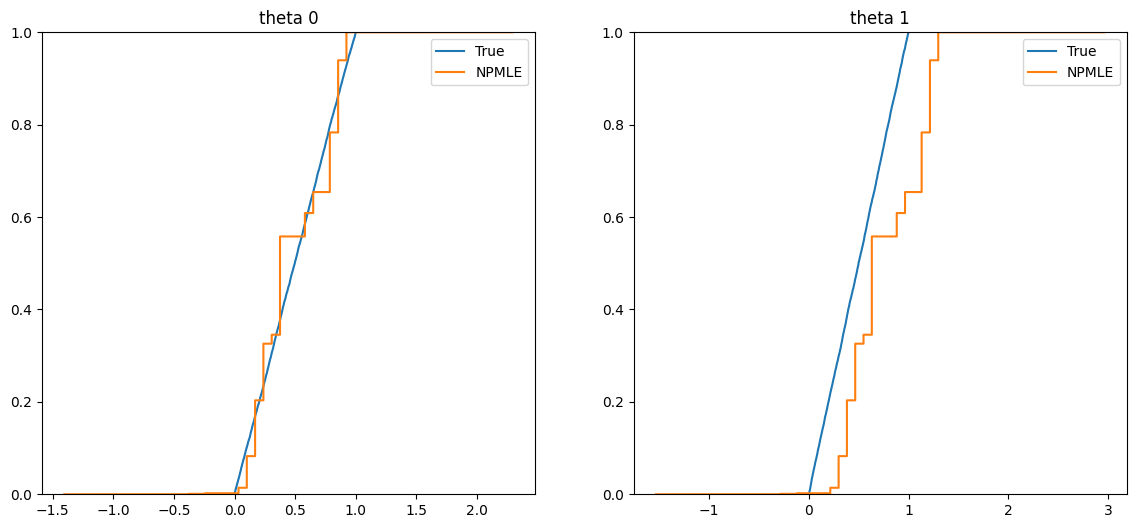

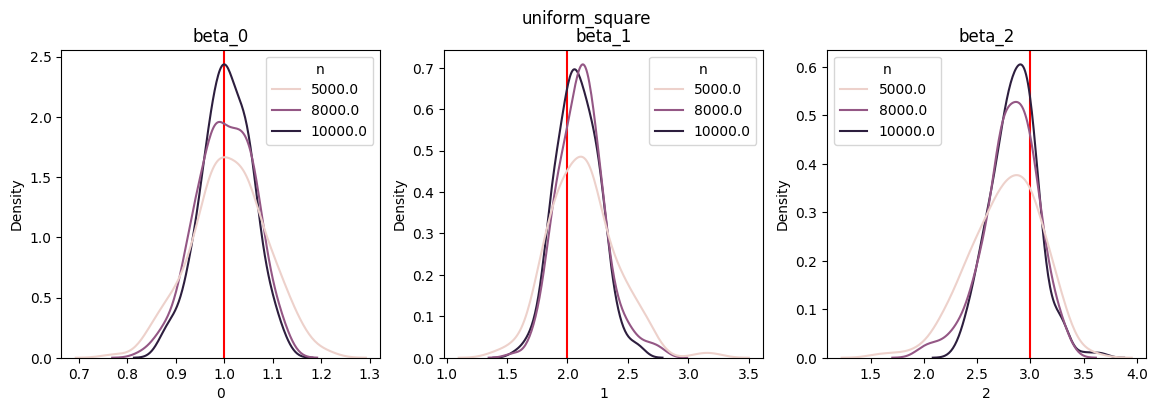

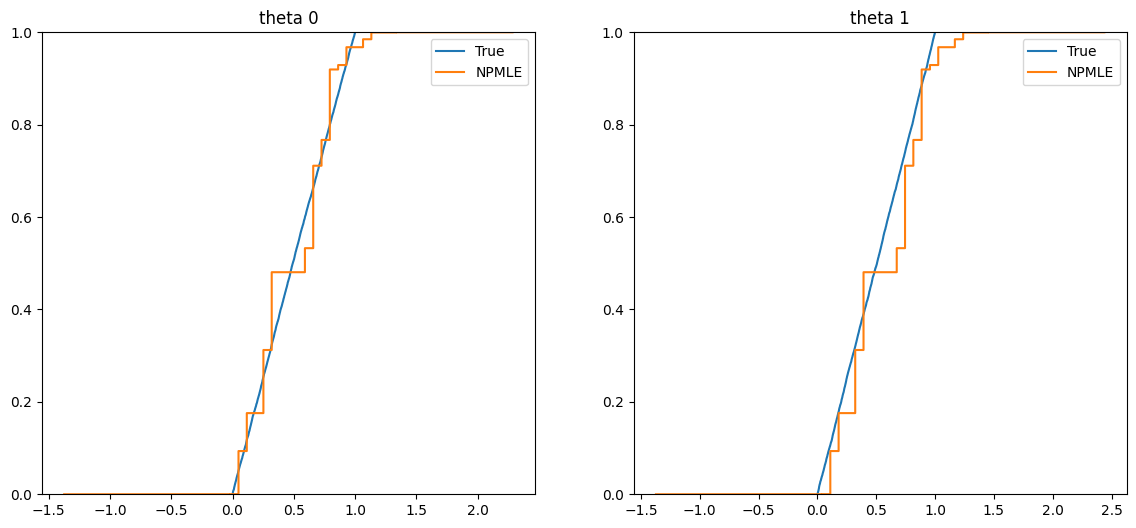

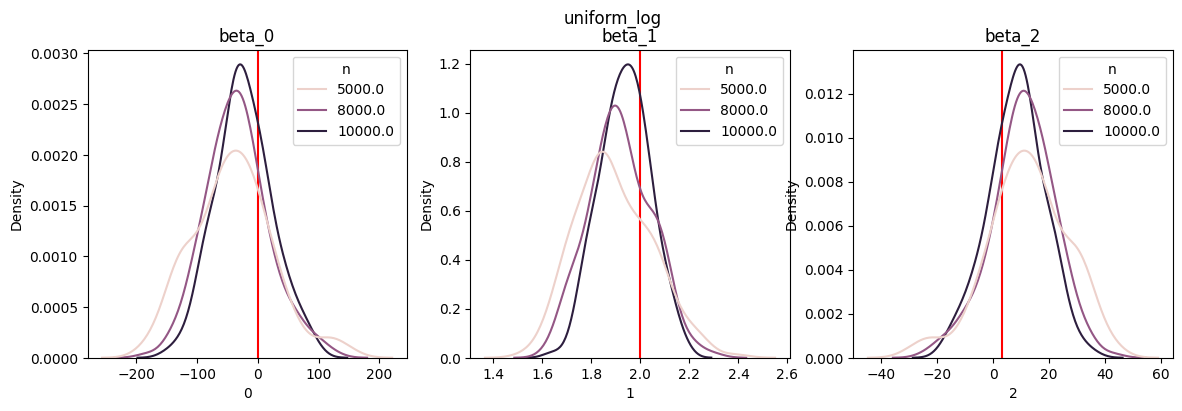

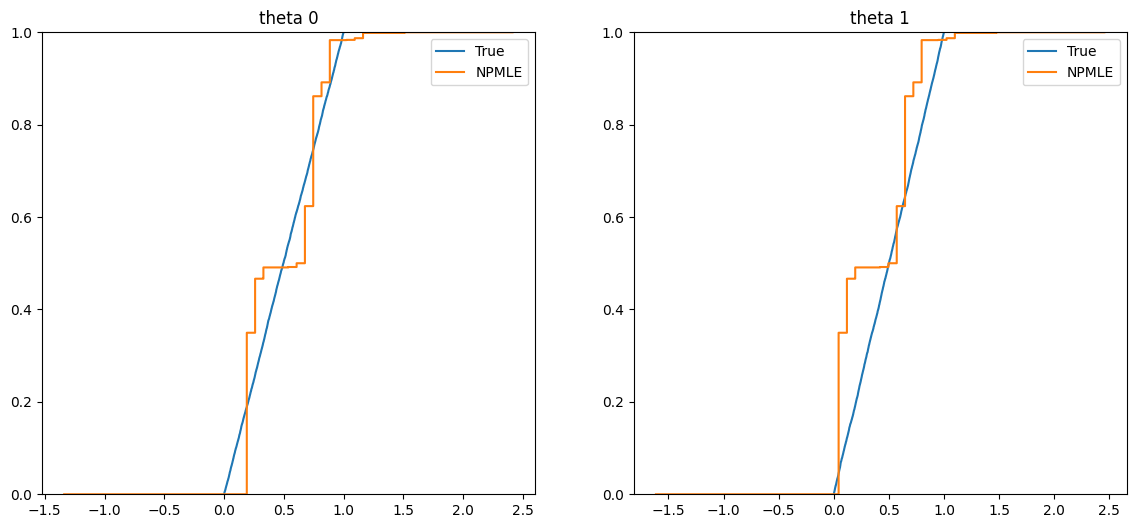

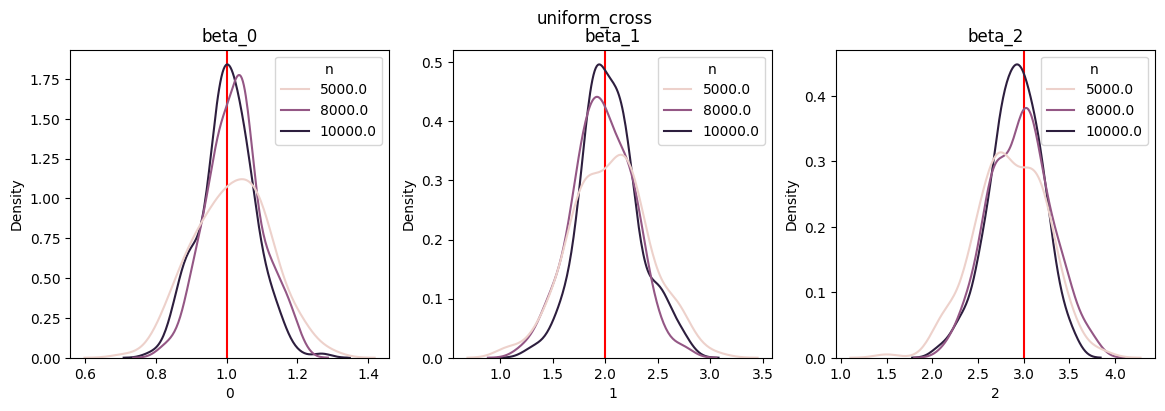

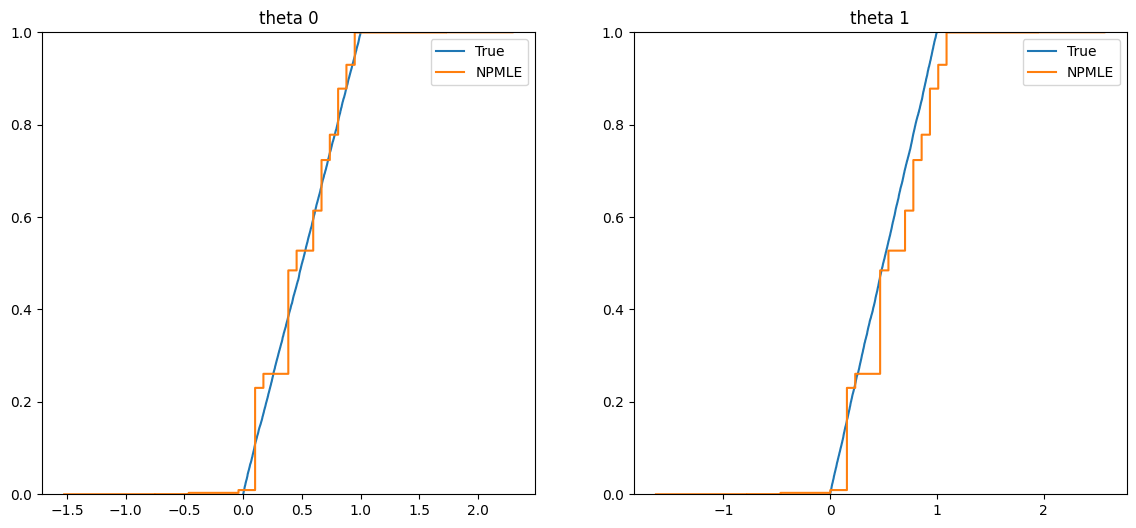

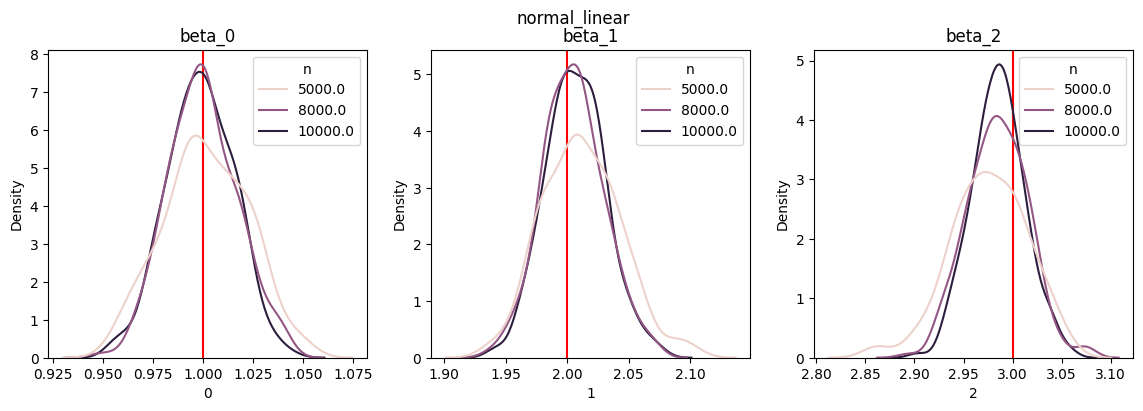

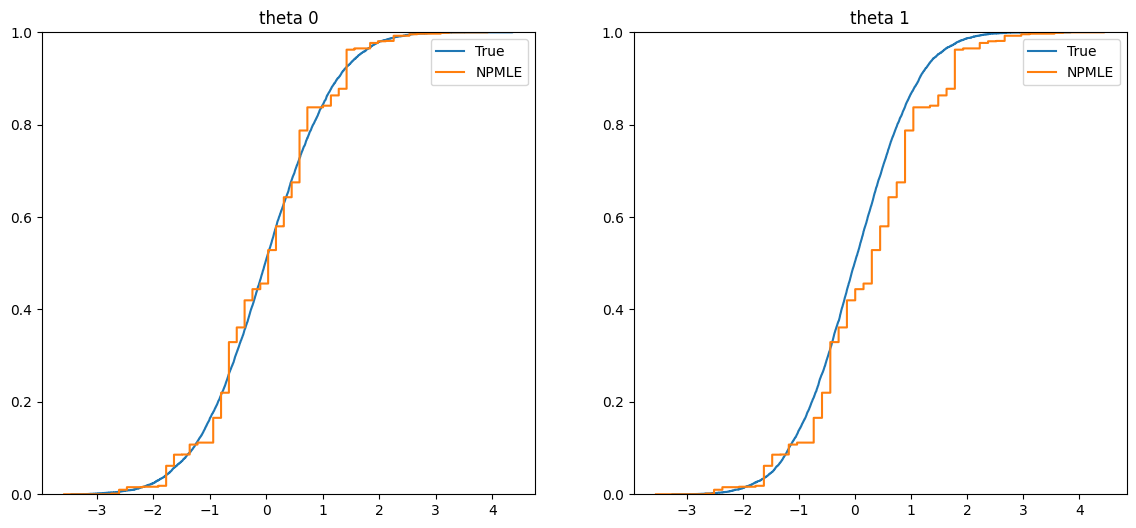

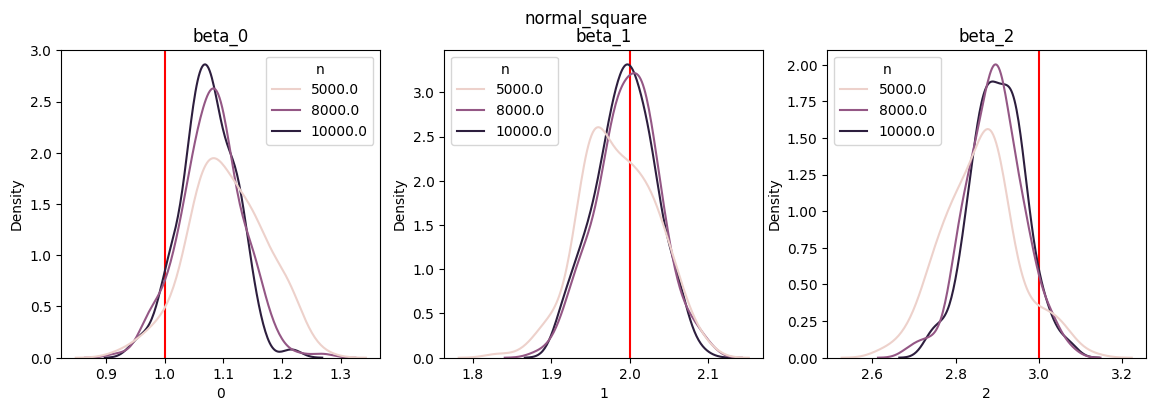

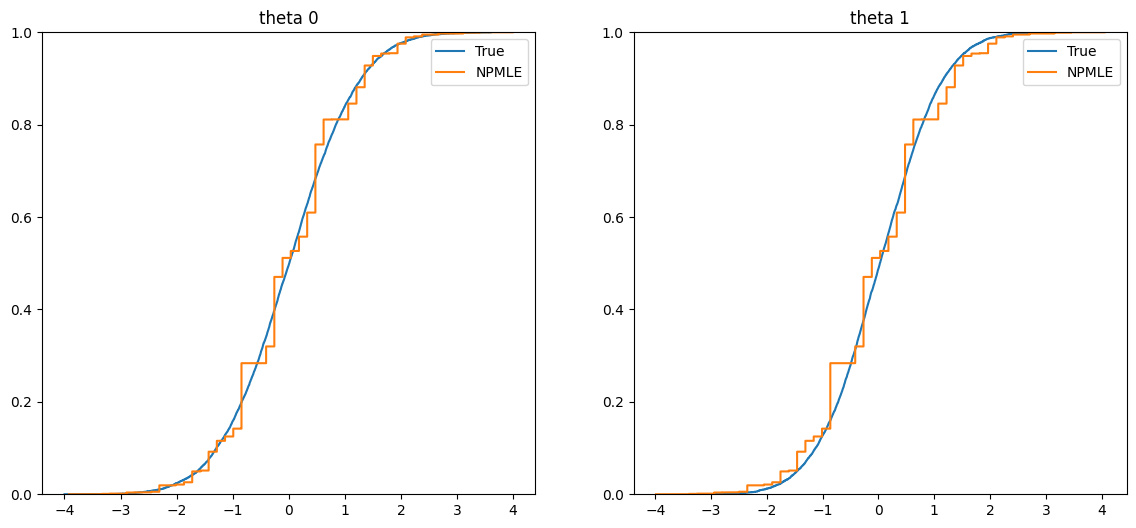

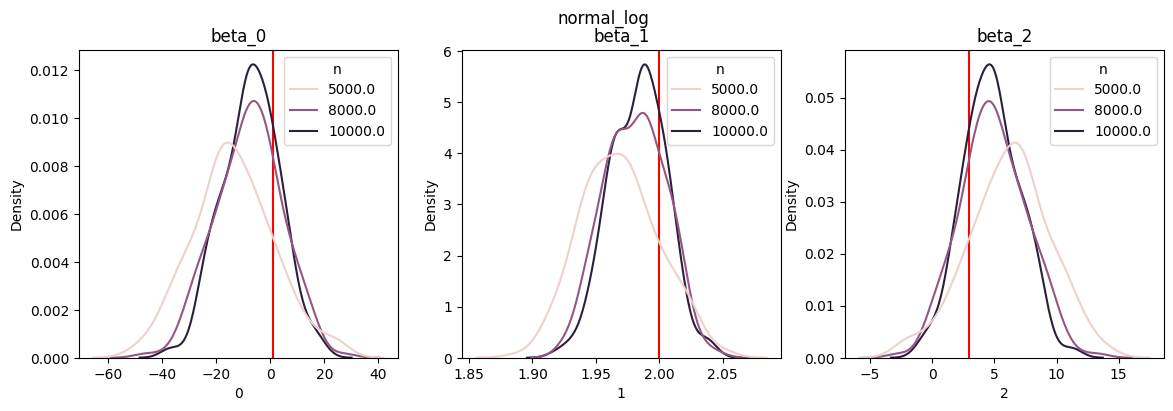

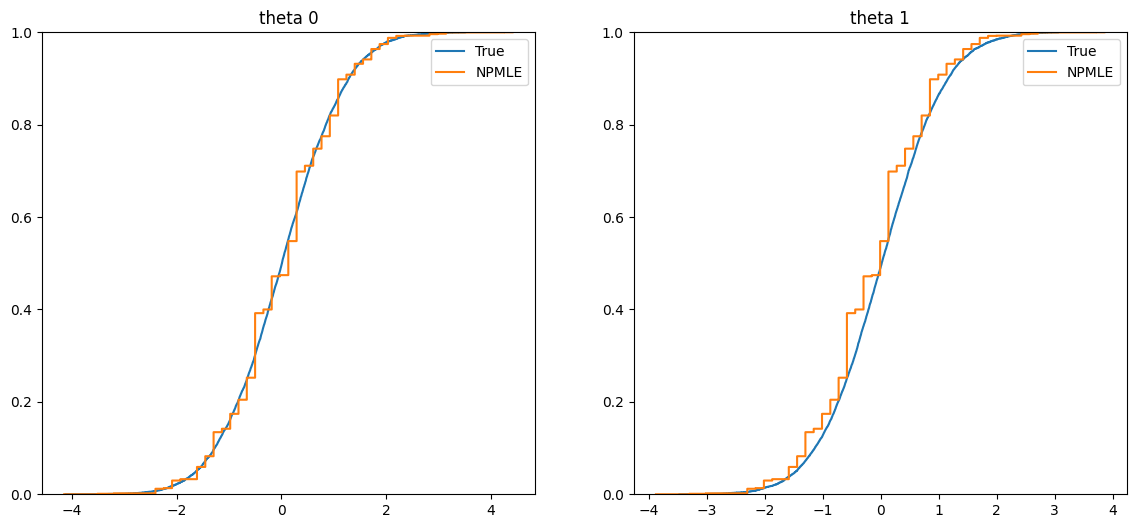

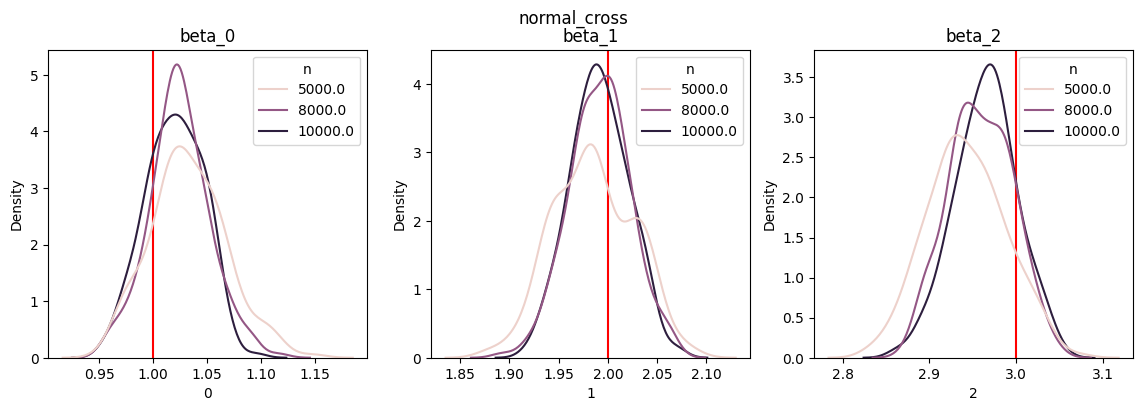

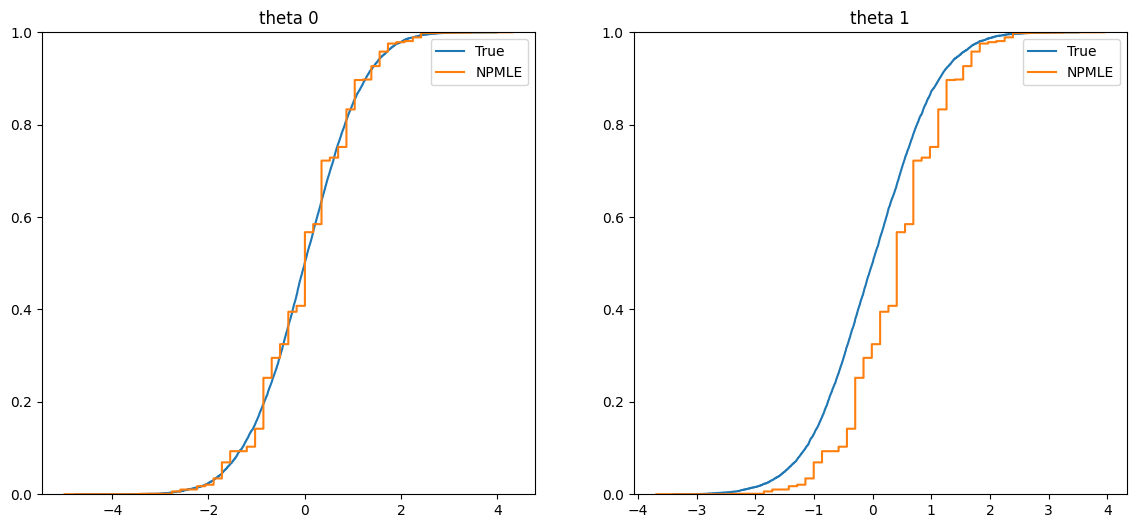

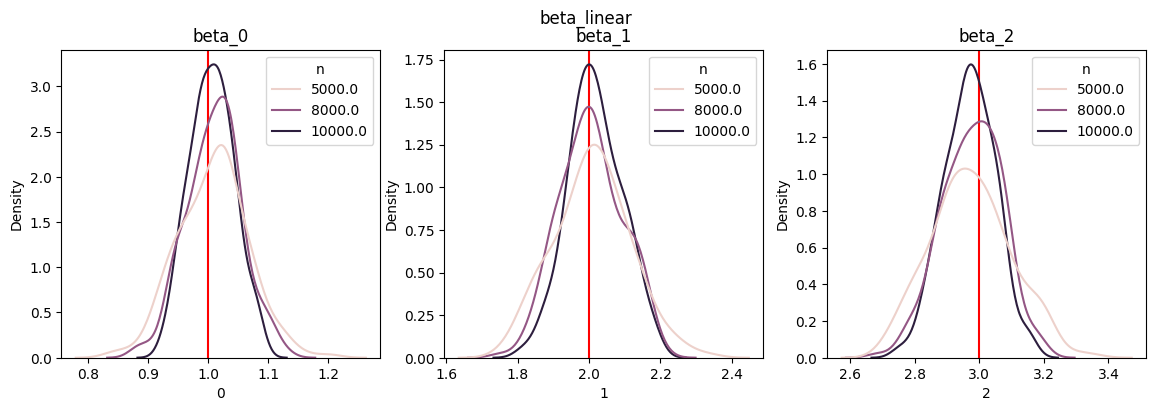

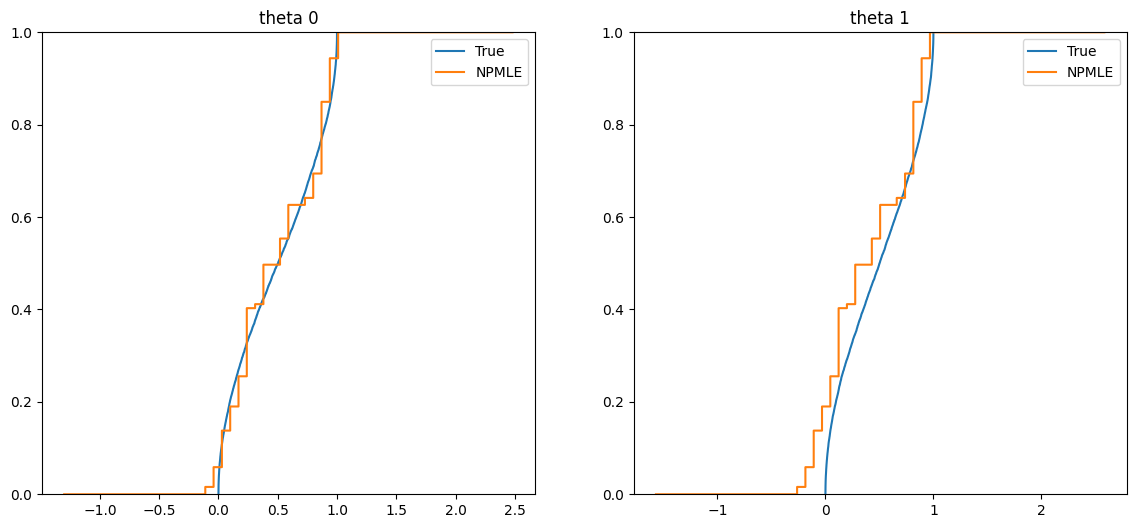

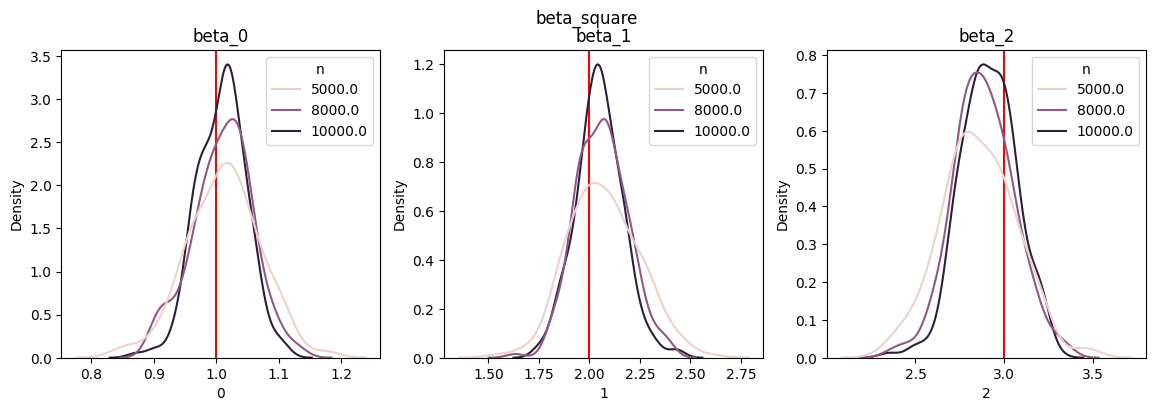

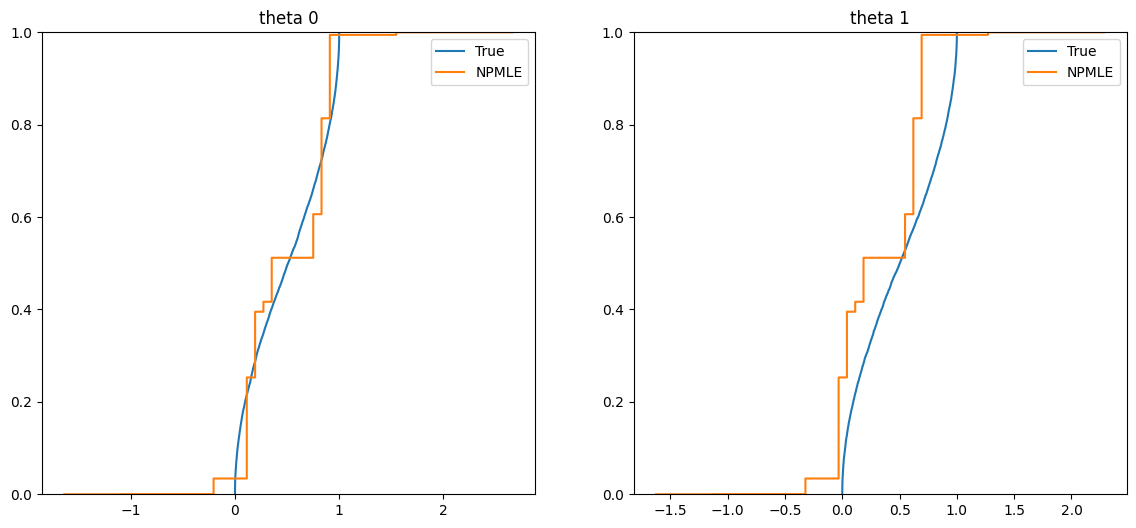

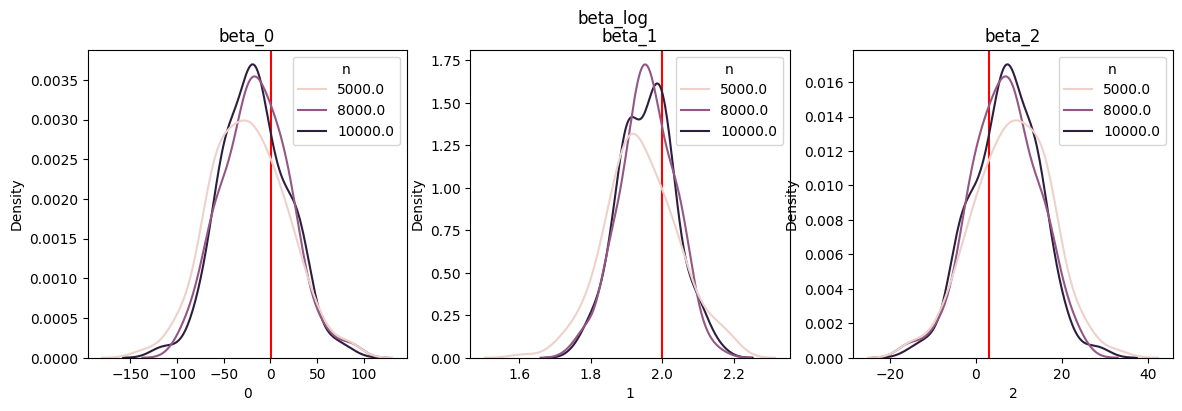

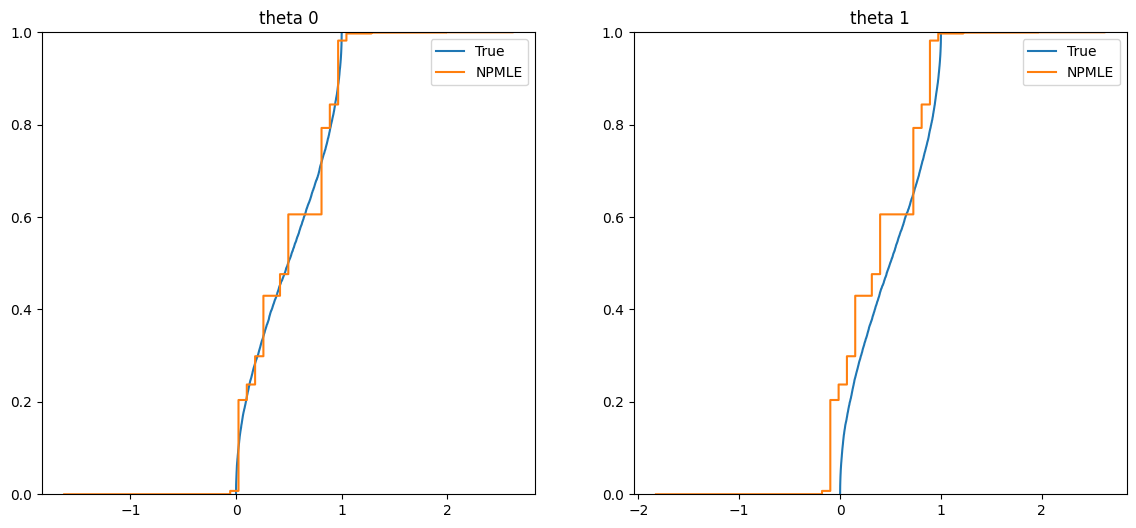

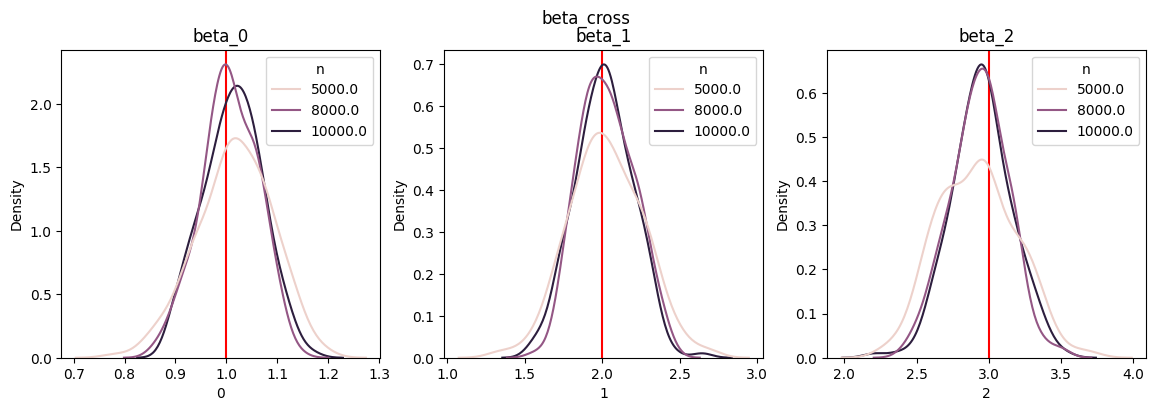

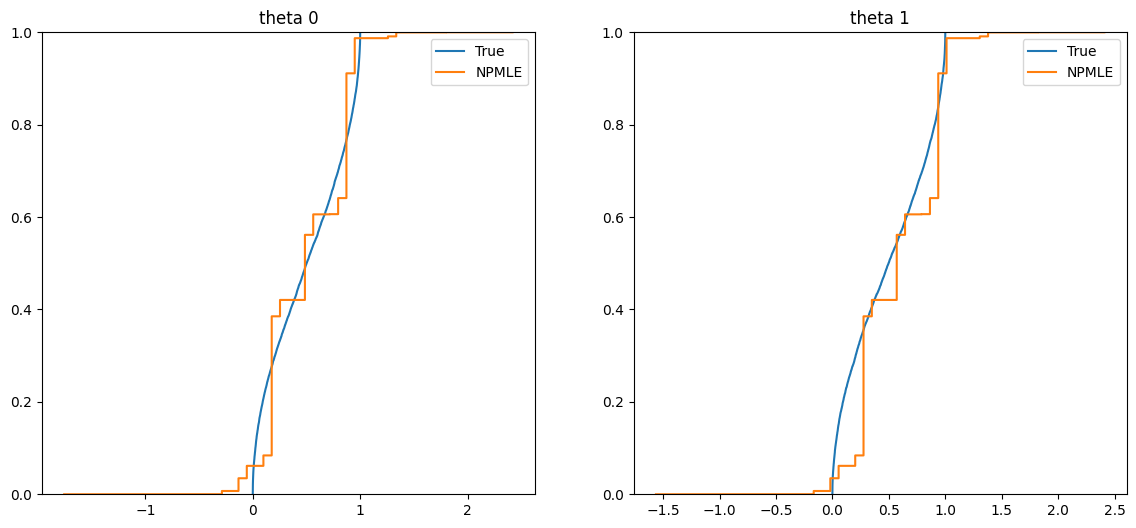

In [21]:
for prior in priors:
    for second_stage in second_stages:
        run_exp(prior, second_stage, True)